In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import shutil
from PIL import Image
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split

import pandas as pd

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
from torchvision.io import read_image

class TrainDataset(Dataset):
    def __init__(self, transform=None):
#         self.img_labels = pd.read_csv('/home/jupyter/mnt/datasets/bhw1/labels.csv')
#         self.img_dir = '../../mnt/datasets/bhw1/trainval/trainval'
        self.img_labels = pd.read_csv("/kaggle/input/bhw-1-deep-learning/bhw1-dataset/labels.csv")
        self.img_dir = "/kaggle/input/bhw-1-deep-learning/bhw1-dataset/trainval"
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    normalize,
])

# test_transform = T.Compose([
#     T.Resize(256),
#     T.CenterCrop(224),
#     T.ToTensor(),
#     normalize,
# ])

In [6]:
dataset = TrainDataset(transform=train_transform)
train, test = random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])
train_loader = DataLoader(train, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False, pin_memory=True)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

# https://github.com/isadrtdinov/intro-to-dl-hse/blob/2022-2023/seminars/202/seminar-04-fine-tuning.ipynb

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [8]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

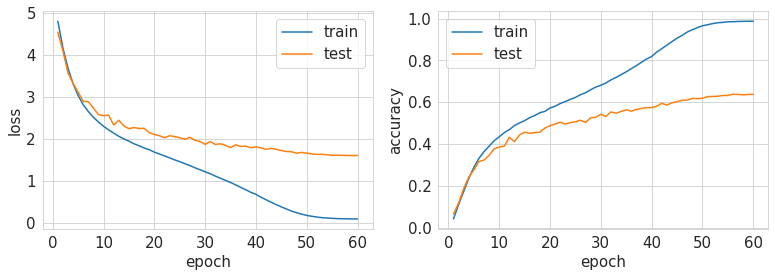

In [22]:
from torchvision.models import resnet34

vec_test = []
vec_train = []

num_epochs = 60
model = resnet34(num_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

torch.save({'model': model.state_dict(),
               'optimizer': optimizer.state_dict(),
               'scheduler': scheduler.state_dict()}, '60ep_model.pth')

In [15]:
class ResultDataset(Dataset):
    def __init__(self, transform=None):
#         self.img_labels = sorted(os.listdir('../../mnt/datasets/bhw1/test/test'))
#         self.img_dir = '../../mnt/datasets/bhw1/test/test'
        self.img_labels = sorted(os.listdir("/kaggle/input/bhw-1-deep-learning/bhw1-dataset/test"))
        self.img_dir = "/kaggle/input/bhw-1-deep-learning/bhw1-dataset/test"
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.img_labels[idx])).convert('RGB')
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [16]:
result_dataset = ResultDataset(transform=train_transform)
result_loader = DataLoader(result_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [10]:
from torchvision.models import resnet34

In [9]:
def train1(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step(test_loss)

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

Возможно тут все пошло плохо, так как нет рандом стейта на трейне и валидации.

Было и на другое количество эпох, но тут больше всего скор (наверно немного рандом), большая часть имела скор 60-61

In [20]:
dataset = TrainDataset(transform=train_transform)
train, test = random_split(dataset, [int(len(dataset)*0.9), len(dataset) - int(len(dataset)*0.9)])
train_loader = DataLoader(train, batch_size=256, shuffle=True, pin_memory=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False, pin_memory=True)

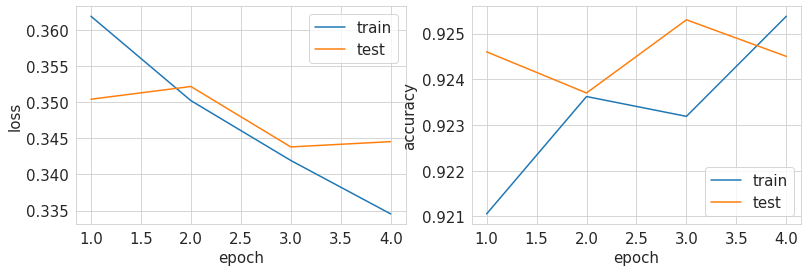

Training 5/5:   0%|          | 0/352 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
state = torch.load('/kaggle/input/60epmodel/60ep_model.pth')
num_epochs = 5
model = resnet34(num_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

model.load_state_dict(state['model'])
model.to(device)

train_losses, test_losses, train_accuracies, test_accuracies = train1(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

torch.save({'model': model.state_dict(),
               'optimizer': optimizer.state_dict(),
               'scheduler': scheduler.state_dict()}, '60cos_20red_model.pth')

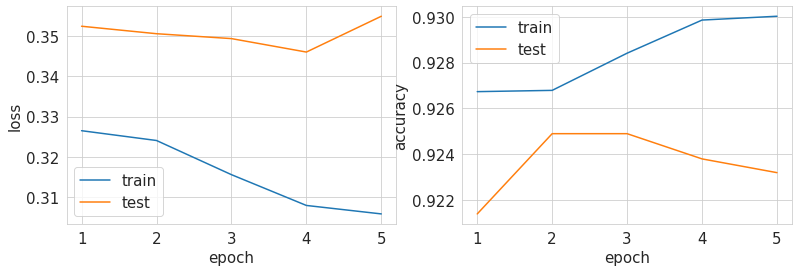

In [29]:
train_losses, test_losses, train_accuracies, test_accuracies = train1(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [30]:
a = {"Id": [], "Label": []}

model.eval()
for im, lab in result_loader:
    im = im.to(device)
    lab = lab
    log = model(im)
    pred = log.argmax(dim=1)
    a["Id"] += lab
    a["Label"] += pred.cpu()

ans = pd.DataFrame(data=a)

for i in range(ans.shape[0]):
    ans["Label"][i] = int(ans["Label"][i].detach().cpu())
ans.to_csv("60 6 " + "predictions.csv", index=False)